# Computing the nonadiabatic couplings in Kohn-Sham and excited states bases

In this tutorial, we will start computing the nonadiabatic couplings (NACs) from the molecular orbital overlap files obtained in [step2](../../7_step2_cp2k/1_DFT). The NACs will be computed in Kohn-Sham states and also in both single-partcile (SP) and many-body (MB) excited state bases. 

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Computing NACs](#comp_nacs)     \
   3.1. [Kohn-Sham basis](#KS)\
   3.2. [Excited state basis](#excited_states)
4. [Plot results](#plot_res)\
   4.1. [NAC map](#nac_map)\
   4.2. [NAC distribution](#nac_dist)
   

### A. Learning objectives

* To be able to compute NACs in Kohn-Sham and excited state bases
* To be able to plot the NAC maps and distributions

### B. Use cases

* [Computing NACs](#comp_nacs)
* [Plot results](#plot_res)

### C. Functions

- `libra_py`
  - `workflows`
    - `nbra`
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Import `glob`, `numpy`, `scipy.sparse`, `matplotlib.pyplot`, and `step3` module which is used to compute the NACs in Kohn-Sham basis using `run_step3_ks_nacs_libint` and in excited states basis using `run_step3_sd_nacs_libint`. 

In [16]:
import os
import glob
import numpy as np
import scipy.sparse as sp
from libra_py import units, data_stat
import matplotlib.pyplot as plt
from liblibra_core import *
from libra_py.workflows.nbra import step3

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

* `../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/res`

The MO overlap files are needed and stored in this folder.

* `../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_logfiles`

All of the logfiles obtained from the electronic structure calculations of CP2K. These files will be needed to find the Kohn-Sham HOMO index and also extract the the TD-DFT data for each step.

## 3. Computing NACs <a name="comp_nacs"></a>
[Back to TOC](#toc)

### 3.1. Kohn-Sham basis <a name="KS"></a>

The `libra_py.workflow.nbra.step3.run_step3_ks_nacs_libint(params)` computes the NACs between pairs of Kohn-Sham states using the molecular orbitals time-overlaps. 

Libra stores the overlap data in 2-spinor format as follows:

<div>
<img src="./active_space_0.png" width="500"/>
</div>

With no spin-orbit couplings, two blocks of the matrix is zero. Since most of the elements of the overlap matrices are zero, we use the `scipy.sparse` library for storing and loading them. 

The paramters for this function are as follows:

`params['lowest_orbital']`: The lowest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['highest_orbital']`: The highest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['num_occ_states']`: The number of occupied orbitals to be considered from HOMO to lower occupied states. This value is defined by user.

`params['num_unocc_states']`: The number of unoccupied orbitals to be considered from LUMO to higher unoccupied states. This value is defined by user.

The two values above are used to create an active space which then will be used to select the elements from the MO overlap and 
energy matrices. 

`params['use_multiprocessing']`: A boolean flag to use the multiprocessing library of Python or not.

`params['nprocs']`: The number of processors to be used for the calculations. Libra will use this only if the `params['use_multiprocessing']` 
is set to `True`.

`params['time_step']`: The time-step used in the calculations in `fs`.

`params['es_software']`: The name of the software package used to compute the electronic structure calculations. This will be used to generate the HOMO 
index of that system so it can build the active space.

`params['path_to_npz_files']`: The full path to the MO overlap files.

`params['logfile_directory']`: The full path to the folder where all the log files are stored.

`params['path_to_save_ks_Hvibs']`: The full path to the folder in which the NACs between the Konh-Sham states are stored.

`params['start_time']`: The start time-step.

`params['finish_time']`: The finish time-step.


After setting all the above paramters, the calculations are run using `step3.run_step3_ks_nacs_libint(params)`.


In [ ]:
params_ks = {
              'lowest_orbital': 24-10, 'highest_orbital': 24+11, 'num_occ_states': 10, 'num_unocc_states': 10,
              'use_multiprocessing': True, 'nprocs': 12, 'time_step': 1.0, 'es_software': 'cp2k',
              'path_to_npz_files': os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/res',
              'logfile_directory': os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_logfiles',
              'path_to_save_ks_Hvibs': os.getcwd()+'/res-ks-DFT',
              'start_time': 1200, 'finish_time': 1401,
            }

#### For KS states - Applying correction to KS overlaps and computing the NACs in KS space
step3.run_step3_ks_nacs_libint(params_ks)

### 3.2. Excited state basis <a name="excited_states"></a>
[Back to TOC](#toc)

Below, we will be using `step3.run_step3_sd_nacs_libint` function to compute the time-overlaps and nonadiabatic couplings between excited states basis. This can be done either in the many-body or single-particle basis. A schematic of the workflow for selecting new active space is shown below:


Some parameters are common with the ones used to run `step3.run_step3_ks_nacs_libint(params)` above.

Other parameters needed to run the `step3.run_step3_sd_nacs_libint(params)` function are as follows:

`params['isUKS']`: A boolean flag for unrestricted spin calculations.

`params['is_many_body']`: If set to `True`, the NACs will be computed between pairs of many-body (TD-DFT) states. Also, the NACs between single-particle 
SDs obtained from the TD-DFT results will be computed as well. Otherwise, only single-particle NACs will be computed only for the SDs obtained from
`num_occ_states` and `num_unocc_states`. This will be used for xTB calculations in which no TD-DFT was performed.

`params['number_of_states']`: The number of TD-DFT states to consider. This value should not exceed the number of requested TD-DFT states in the CP2K
calculations.

`params['tolerance']`: A lower bound for selection of the excitation with configuration interaction coefficients higher than this value.

`params['verbosity']`: An integer value showing the printing level. The default is set to 0. Higher values will print more data on the terminal.

`params['sorting_type']`: After defining the SDs, Libra will sort them either based on `'energy'` or `'identity'`.


The NACs can also be computed between excited states. These include the single-particle and many-body bases which the latter is obtained from the
TD-DFT calculations. First, we need to compute the overlap between excited state Slater-determinants (SDs) then they will be used to compute the NACs
between them. For many-body states, the configuration interaction coefficietns will be used. We will consider both single-particle 
and many-body for DFT calculations but only single-particle for xTB.

There are different ways of defining the excited states SDs (the single-particle excited state basis). The first is through 
defining the `num_occ_states` and `num_unocc_states` in which Libra
will start making the SDs from all of the occupied states (starting from `HOMO-num_occ_states+1`) to all of the unoccupied states (ends
to `LUMO+num_unocc_states-1`). Also, if the unrestricted spin calculation flag is set to `True`, the SDs will be made for both alpha and beta spin channels. 

For example, if you want to build the electron-only excitation basis, you need to set `params['num_occ_states'] = 1` and set `params['num_unocc_states']`
to a value less than the number of unoccupied orbitals that was considered in the computation of overlaps. This will generate all the electron-only
excitation from HOMO to unoccupied states.

If the TD-DFT calculations has been done, then Libra will go over all log files and 
generate all the SDs used for all the steps and therefore the definition of these SDs is automatic and Libra will replace the `num_occ_states` and
`num_unocc_states` itself based on the SDs that were generated from the TD-DFT log files. 



In [ ]:
params_mb_sd = {
          'lowest_orbital': 24-10, 'highest_orbital': 24+11, 'num_occ_states': 10, 'num_unocc_states': 10,
          'isUKS': 0, 'number_of_states': 10, 'tolerance': 0.01, 'verbosity': 0, 'use_multiprocessing': True, 'nprocs': 12,
          'is_many_body': True, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/res',
          'logfile_directory': os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/1_example_TiO2/all_logfiles',
          'path_to_save_sd_Hvibs': os.getcwd()+'/res-mb-sd-DFT',
          'outdir': os.getcwd()+'/res-mb-sd-DFT', 'start_time': 1200, 'finish_time': 1401, 'sorting_type': 'identity',
         }

step3.run_step3_sd_nacs_libint(params_mb_sd)

## 4. Plot results <a name="plot_res"></a>
[Back to TOC](#toc)

Here, we compare the NAC magnitudes of the single-particle and many-body bases using two different methods.

### 4.1. NAC map <a name="nac_map"></a>

One way of visualizing the NAC values is to plot the average NAC matrix using `plt.imshow`. 

<IPython.core.display.Javascript object>


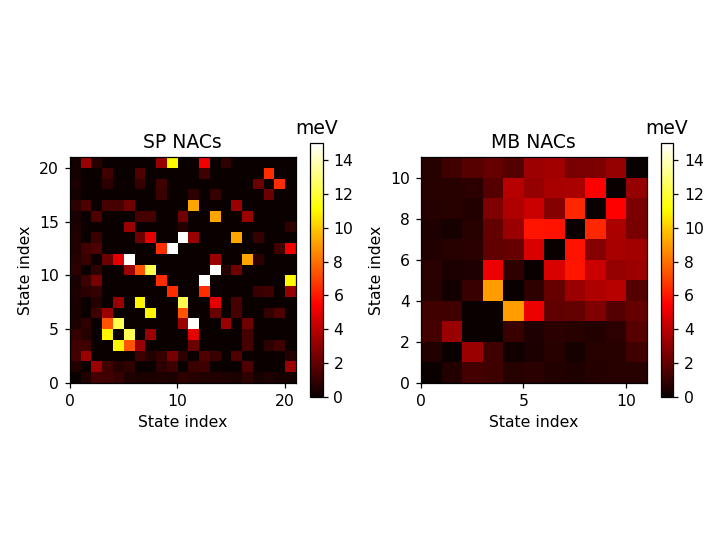

In [9]:
%matplotlib notebook
plt.figure()
titles = ['SP','MB']
for c1, basis in enumerate(['sd', 'ci']):
    plt.subplot(1, 2, c1+1)
    nac_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*im*')
    for c2, nac_file in enumerate(nac_files):
        nac_mat = sp.load_npz(nac_file).todense().real
        if c2==0:
            nac_ave = np.zeros(nac_mat.shape)
        nac_ave += np.abs(nac_mat)
    nac_ave *= 1000*units.au2ev/c2
    nstates = nac_ave.shape[0]
    plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
    plt.xlabel('State index')
    plt.ylabel('State index')
    colorbar = plt.colorbar(shrink=0.50)
    colorbar.ax.set_title('meV')
    plt.clim(vmin=0, vmax=15)
    plt.title(F'{titles[c1]} NACs')
    plt.tight_layout()

### 4.1. NAC distribution <a name="nac_dist"></a>
[Back to TOC](#toc)

Another intuitive way to visualize the NACs is to plot the distribution of the NACs. Here we plot them for SP and MB excited states. A smoother distribution plot is obtained if more steps are involved.

<IPython.core.display.Javascript object>


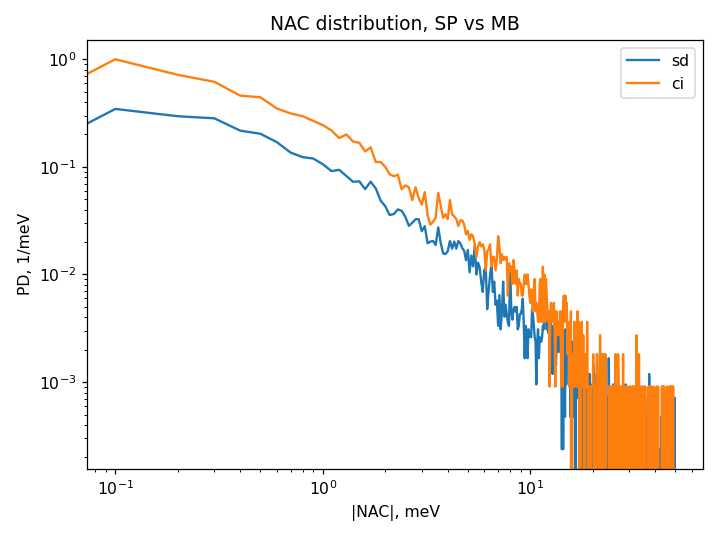

In [15]:
%matplotlib notebook

for basis in ['sd','ci']:
    nac = []
    nac_files = glob.glob(F'res-mb-sd-DFT/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp, dens, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp, dens, label=basis)
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution, SP vs MB')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
# plt.savefig('nac_dist_1.jpg', dpi=600)